# MatchCake Example


<table class="nt-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://MatchCake.github.io/MatchCake/"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/logo_32px.png?raw=true" width=32px height=32px  />Documentation</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MatchCake/MatchCake/blob/main/tutorials/matchcake_basics.ipynb"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/colab_logo_32px.png?raw=true" width=32px height=32px  />Run in Google Colab</a>
</td>
  <td>
    <a target="_blank" href="https://github.com/MatchCake/MatchCake/blob/main/tutorials/matchcake_basics.ipynb"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width=32px height=32px />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/download_logo_32px.png?raw=true" width=32px height=32px />Download notebook</a>
  </td>
</table>

In this example, we will use the `matchcake` library to create a simple quantum circuit using the `NonInteractingFermionicDevice` and the `fRXX`, `fRYY`, `fRZZ`, and `fSWAP` operations. We will then use PennyLane to create a QNode and evaluate the expectation value of the circuit.

# Setup

You can now install the dependencies by running the following commands:

In [ ]:
#@title Install dependencies {display-mode: "form"}

RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    !git clone https://github.com/MatchCake/MatchCake.git
    !pip install -r MatchCake/requirements.txt
    !pip install git+https://github.com/MatchCake/MatchCake.git
else:
    !pip install -r ../requirements.txt

# Imports

We start by importing the necessary libraries.

In [1]:
import matchcake as mc
import pennylane as qml
import numpy as np
from pennylane.ops.qubit.observables import BasisStateProjector

E:\Github\MatchCake\p310venv\lib\site-packages\pennylane\__init__.py:184: PennyLaneDeprecationWarning: QubitDevice will no longer be accessible top level. Please access the class as pennylane.devices.QubitDevice
  warn(


# Create the NonInteractingFermionicDevice

We start by creating a `NonInteractingFermionicDevice` with 4 wires. We also define the initial state as the zero state.

In [2]:
nif_device = mc.NonInteractingFermionicDevice(wires=10, show_progress=True)
initial_state = np.zeros(len(nif_device.wires), dtype=int)

# Define the circuit

We define a simple circuit that applies the `fRXX`, `fRYY`, `fRZZ`, and `fSWAP` operations to the initial state. We also include a `BasisStateProjector` to measure the expectation value of the circuit.

In [3]:
def circuit(params, wires, initial_state=None):
    """
    Circuit that applies the fRXX, fRYY, fRZZ, and fSWAP operations to the initial state.
    
    :param params: The parameters of the circuit. It should have shape (batch_size, 2, n_layers). 
    :param wires: The wires of the circuit.
    :param initial_state: The initial state of the circuit. It should be a numpy array with shape (len(wires),) of zeros and ones.
    :return: The expectation value of the circuit.
    """
    qml.BasisState(initial_state, wires=wires)
    batch_size, n_gate_params, n_layers = qml.math.shape(params)
    if n_gate_params != 2:
        raise ValueError("The number of gate parameters should be 2.")
    for layer in range(n_layers):
        layer_params = params[..., layer]
        for i, even_wire in enumerate(wires[:-1:2]):
            idx = list(wires).index(even_wire)
            curr_wires = [wires[idx], wires[idx + 1]]
            mc.operations.fRXX(layer_params, wires=curr_wires)
            mc.operations.fRYY(layer_params, wires=curr_wires)
            mc.operations.fRZZ(layer_params, wires=curr_wires)
        for i, odd_wire in enumerate(wires[1:-1:2]):
            idx = list(wires).index(odd_wire)
            mc.operations.fSWAP(wires=[wires[idx], wires[idx + 1]])
    projector: BasisStateProjector = qml.Projector(initial_state, wires=wires)
    return qml.expval(projector)

# Create the QNode

We create a QNode using PennyLane and the `NonInteractingFermionicDevice` we defined earlier.

In [4]:
nif_qnode = qml.QNode(circuit, nif_device)

# Define the hyperparameters of the circuit

In [5]:
n_layers = 3  # Number of layers
n_gate_params = 2  # Number of parameters per gate

# Draw the circuit

We can draw the circuit using PennyLane's `draw_mpl` function.

(<Figure size 1600x1100 with 1 Axes>, <Axes: >)

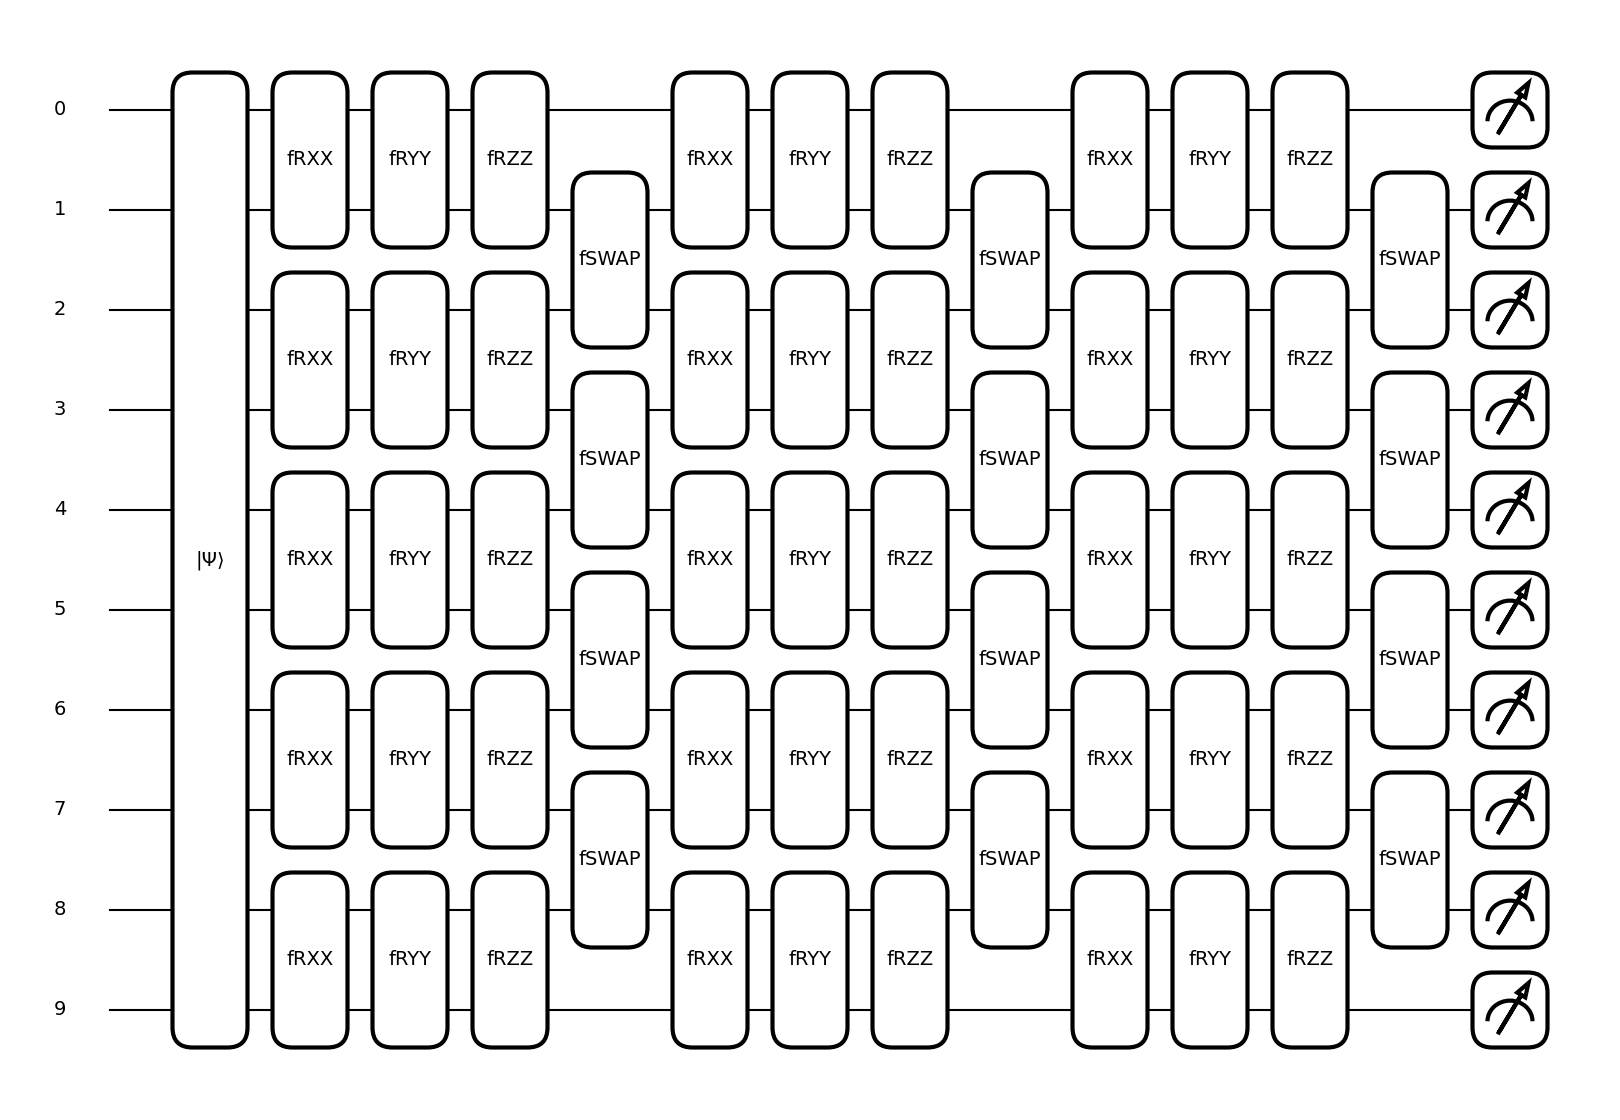

In [6]:
dummy_params = np.random.random((1, n_gate_params, n_layers))
qml.draw_mpl(nif_qnode)(dummy_params, wires=nif_device.wires, initial_state=initial_state)

# Evaluate the QNode

We can now evaluate the QNode using some random parameters and a batch size of 4.

In [7]:
params = np.random.random((4, n_gate_params, n_layers))

In [8]:
expval = nif_qnode(params, wires=nif_device.wires, initial_state=initial_state)

Computing Lookup Table Items: 100%|██████████| 4/4 [00:00<00:00, 279.98it/s, Finished the computation of the observable.] 


# Print the expectation values

We print the expectation values of the circuit.

In [9]:
print(f"Expectation values: {expval}")

Expectation values: tensor([0.0030, 0.2839, 0.1802, 0.0094], dtype=torch.float64)
